🚀 **STARTING COMPLETE LIVER TUMOR SEGMENTATION**
🔍 **Mapping tumor masks...**
Processing patient directory: 7
  Found 151 tumor mask files
Processing patient directory: 17
  Found 119 tumor mask files
Processing patient directory: 19
  Found 124 tumor mask files
Processing patient directory: 2
  Found 172 tumor mask files
Processing patient directory: 10
  Found 122 tumor mask files
Processing patient directory: 5
  Found 139 tumor mask files
Processing patient directory: 20
  Found 225 tumor mask files
Processing patient directory: 8
  Found 124 tumor mask files
Processing patient directory: 12
  Found 260 tumor mask files
Processing patient directory: 18
  Found 74 tumor mask files
Processing patient directory: 16
  Found 155 tumor mask files
Processing patient directory: 13
  Found 122 tumor mask files
Processing patient directory: 15
  Found 125 tumor mask files
Processing patient directory: 3
  Found 200 tumor mask files
Processing patient directory: 1
  Found 129 tumor mask files

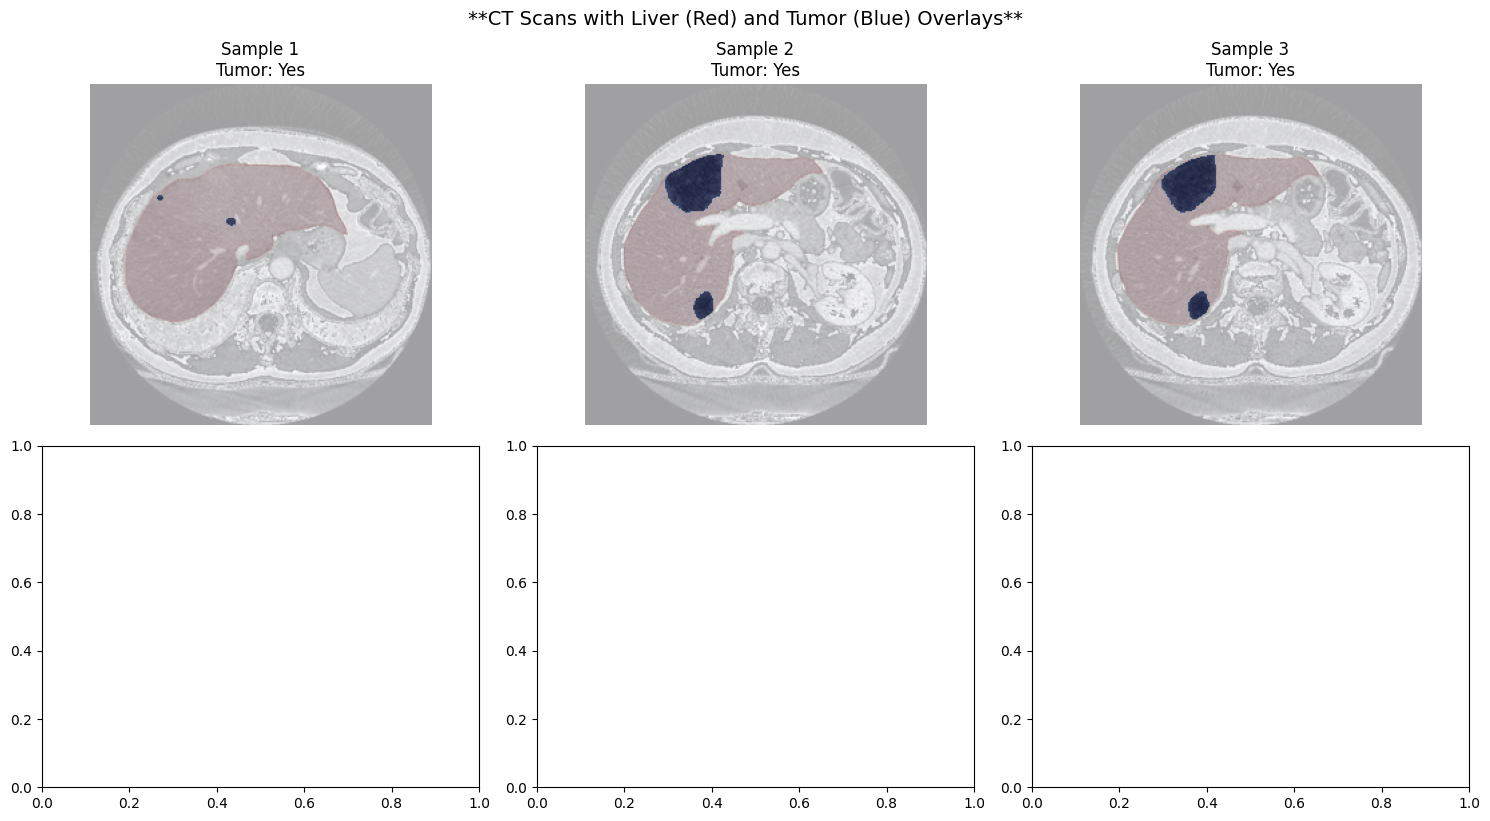

Files with tumors: 445
Files without tumors: 1813
Files with tumors: 118
Files without tumors: 447
Using device: cuda
🚀 **Starting COMPLETE Enhanced Training...**
Expected loss range: 0.1-0.5 initially, converging to 0.02-0.05
**Epoch  1** | Loss: 0.7491/0.7263 | Liver: 0.0788 (0.0806) | **Tumor: 0.0044 (0.0023)**
**Epoch  2** | Loss: 0.7114/0.7003 | Liver: 0.1291 (0.5189) | **Tumor: 0.0053 (0.1925)**
**Epoch  3** | Loss: 0.6840/0.6821 | Liver: 0.2419 (0.8685) | **Tumor: 0.0238 (0.9046)**
**Epoch  4** | Loss: 0.6627/0.6626 | Liver: 0.3430 (0.9173) | **Tumor: 0.0647 (0.9296)**
**Epoch  5** | Loss: 0.6305/0.6194 | Liver: 0.6435 (0.9787) | **Tumor: 0.3590 (0.9839)**
**Epoch  6** | Loss: 0.6065/0.5893 | Liver: 0.7333 (0.9826) | **Tumor: 0.5841 (0.9916)**
**Epoch  7** | Loss: 0.5736/0.5780 | Liver: 0.4699 (0.9612) | **Tumor: 0.3557 (0.9827)**
**Epoch  8** | Loss: 0.5494/0.5311 | Liver: 0.8025 (0.9868) | **Tumor: 0.7966 (0.9957)**
**Epoch  9** | Loss: 0.5164/0.5009 | Liver: 0.7453 (0.9848) |

/tmp/ipykernel_19/2246722056.py:616: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/2246722056.py:616: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


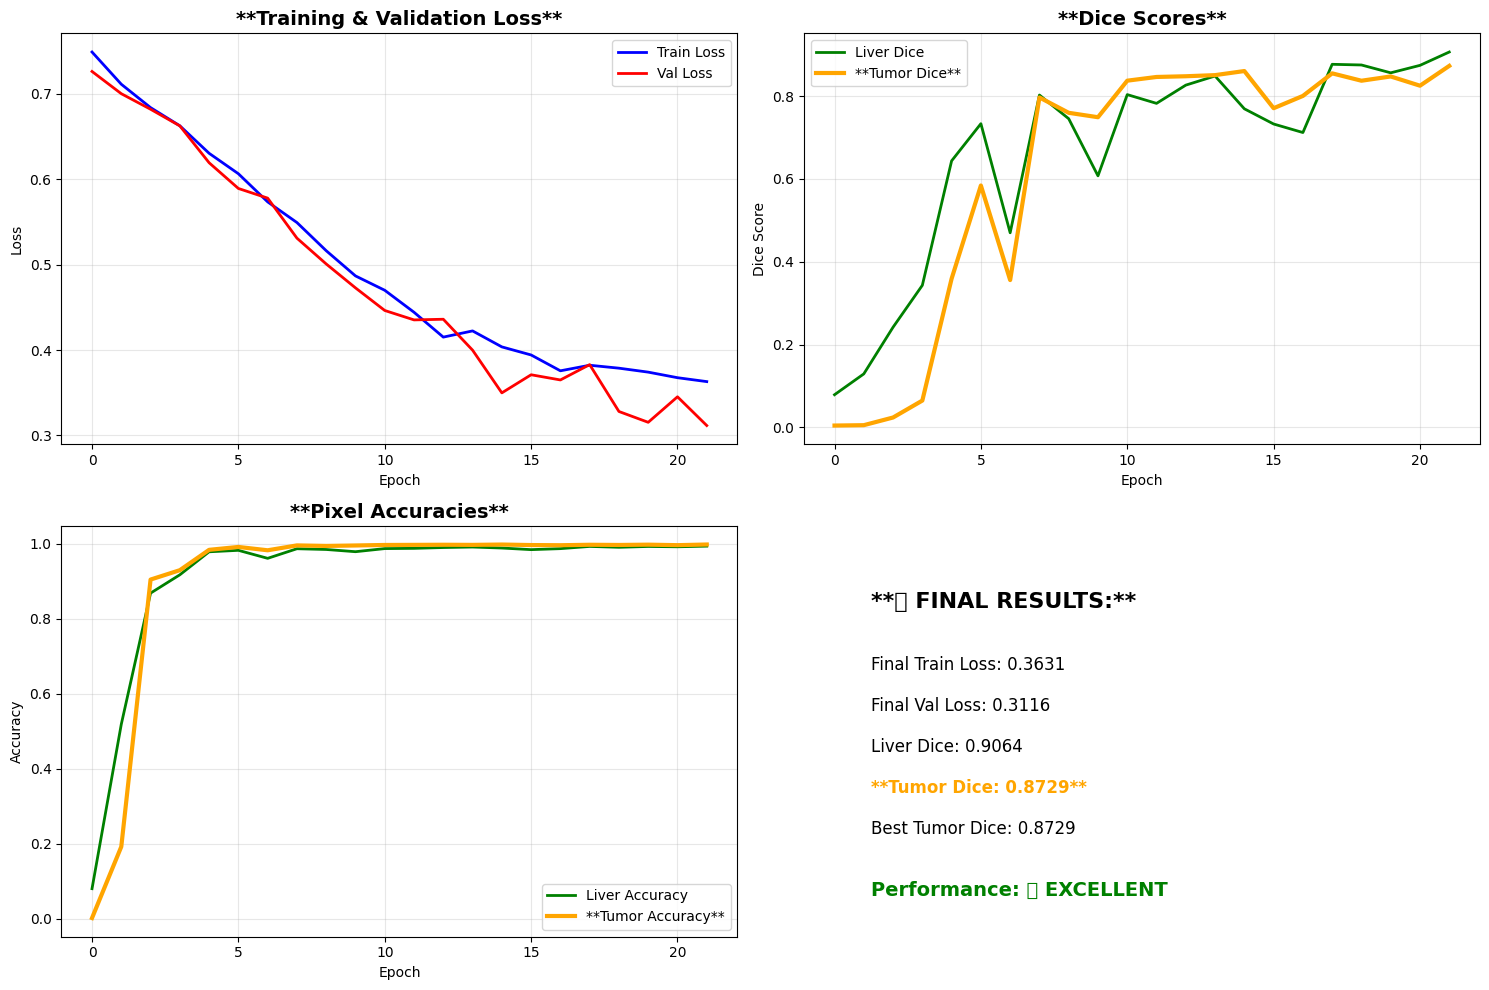

🔍 **Mapping tumor masks...**
Processing patient directory: 7
  Found 151 tumor mask files
Processing patient directory: 17
  Found 119 tumor mask files
Processing patient directory: 19
  Found 124 tumor mask files
Processing patient directory: 2
  Found 172 tumor mask files
Processing patient directory: 10
  Found 122 tumor mask files
Processing patient directory: 5
  Found 139 tumor mask files
Processing patient directory: 20
  Found 225 tumor mask files
Processing patient directory: 8
  Found 124 tumor mask files
Processing patient directory: 12
  Found 260 tumor mask files
Processing patient directory: 18
  Found 74 tumor mask files
Processing patient directory: 16
  Found 155 tumor mask files
Processing patient directory: 13
  Found 122 tumor mask files
Processing patient directory: 15
  Found 125 tumor mask files
Processing patient directory: 3
  Found 200 tumor mask files
Processing patient directory: 1
  Found 129 tumor mask files
Processing patient directory: 14
  Found 113 tum

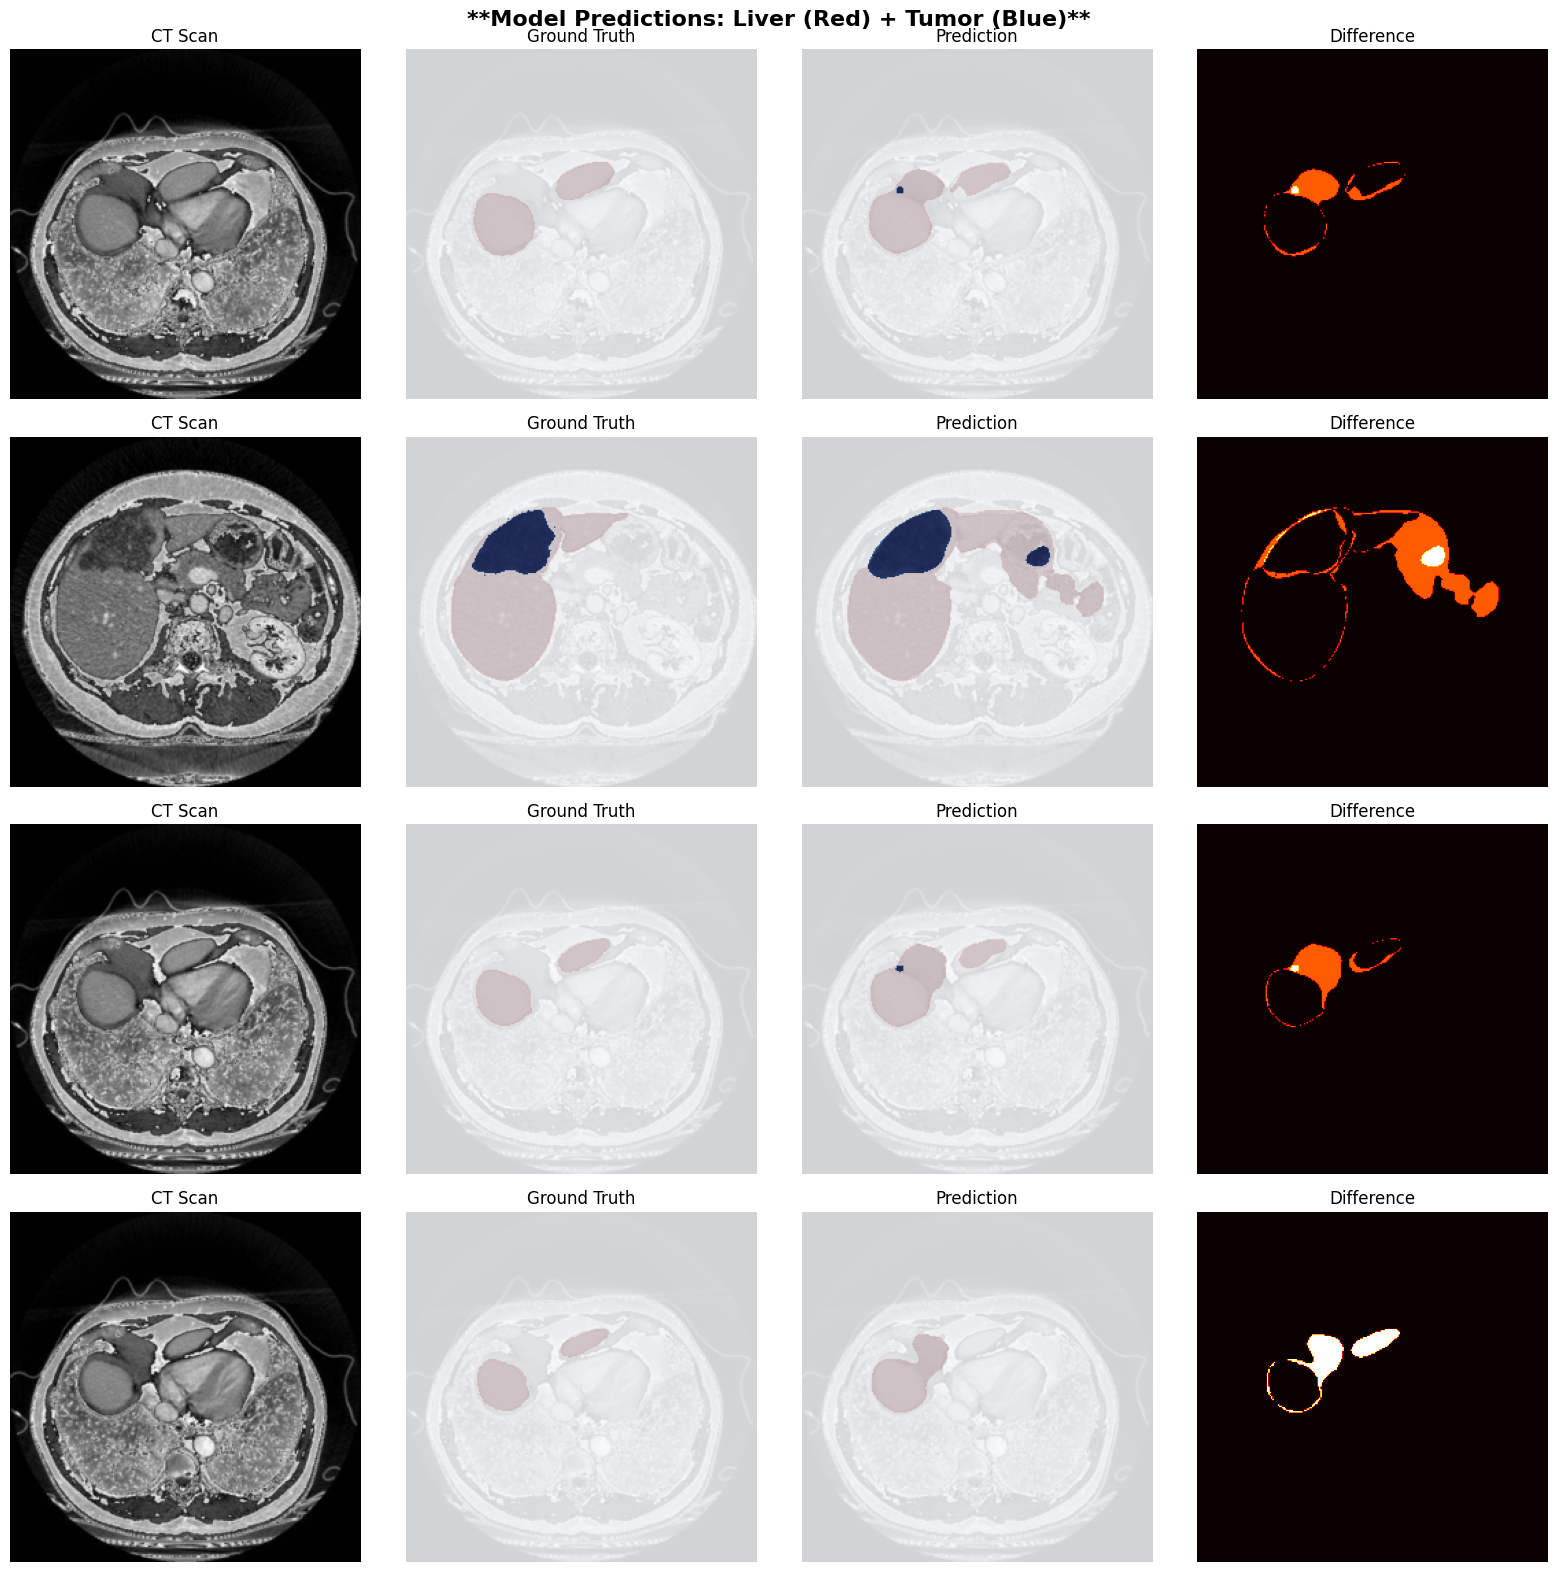

🎉 **TRAINING COMPLETED SUCCESSFULLY!**
Best tumor dice score achieved: 0.8729


In [1]:
# ============================================================
# 🧠 COMPLETE LIVER + TUMOR SEGMENTATION WITH FIXES
# ============================================================

import os
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T

# ============================================================
# 📁 DATASET PATHS
# ============================================================
IMAGE_DIR = '/kaggle/input/3dircadb-dataset/Liver Segmentation Dataset/images'
LIVER_MASK_DIR = '/kaggle/input/3dircadb-dataset/Liver Segmentation Dataset/liver_masks'
TUMOR_MASK_ROOT = '/kaggle/input/3dircadb-dataset/Liver Segmentation Dataset/tumor_masks'
IMAGE_SIZE = (256, 256)

# ============================================================
# 🔍 DATASET ANALYSIS AND MAPPING
# ============================================================

def create_tumor_mask_mapping():
    """Create mapping of tumor masks"""
    tumor_mask_map = {}
    print("🔍 **Mapping tumor masks...**")
    
    for patient_dir in glob.glob(f'{TUMOR_MASK_ROOT}/*'):
        patient_name = os.path.basename(patient_dir)
        print(f"Processing patient directory: {patient_name}")
        
        if os.path.isdir(patient_dir):
            tumor_files = os.listdir(patient_dir)
            print(f"  Found {len(tumor_files)} tumor mask files")
            
            for tumor_file in tumor_files:
                tumor_mask_map[tumor_file] = os.path.join(patient_dir, tumor_file)
    
    print(f"**Total tumor masks mapped: {len(tumor_mask_map)}**")
    return tumor_mask_map

def analyze_dataset_distribution(img_dir, liver_dir, tumor_map):
    """Analyze the distribution of liver and tumor masks"""
    all_files = sorted(os.listdir(img_dir))
    
    stats = {
        'total_images': len(all_files),
        'has_liver_mask': 0,
        'has_tumor_mask': 0,
        'tumor_mask_sizes': [],
        'liver_mask_sizes': []
    }
    
    print("📊 **Dataset Analysis:**")
    print(f"Total images: {stats['total_images']}")
    
    for fname in all_files[:200]:  # Sample first 200 for analysis
        liver_path = os.path.join(liver_dir, fname)
        tumor_path = tumor_map.get(fname, None)
        
        if os.path.exists(liver_path):
            stats['has_liver_mask'] += 1
            liver_mask = np.array(Image.open(liver_path).convert('L'))
            stats['liver_mask_sizes'].append(np.sum(liver_mask > 0))
        
        if tumor_path and os.path.exists(tumor_path):
            stats['has_tumor_mask'] += 1
            tumor_mask = np.array(Image.open(tumor_path).convert('L'))
            tumor_pixels = np.sum(tumor_mask > 0)
            if tumor_pixels > 50:  # Minimum threshold
                stats['tumor_mask_sizes'].append(tumor_pixels)
        else:
            stats['tumor_mask_sizes'].append(0)
    
    print(f"Images with liver masks: {stats['has_liver_mask']}")
    print(f"Images with significant tumor masks: {stats['has_tumor_mask']}")
    print(f"**Tumor presence rate: {stats['has_tumor_mask']/200*100:.1f}%**")
    
    return stats

def visualize_dataset_samples(img_dir, liver_dir, tumor_map, num_samples=6):
    """Visualize CT scans with liver and tumor mask overlays"""
    all_files = sorted(os.listdir(img_dir))
    
    # Find samples with and without tumors
    tumor_samples = []
    no_tumor_samples = []
    
    for fname in all_files[:500]:  # Check first 500 files
        tumor_path = tumor_map.get(fname, None)
        if tumor_path and os.path.exists(tumor_path):
            tumor_mask = np.array(Image.open(tumor_path).convert('L'))
            if np.sum(tumor_mask > 0) > 100:  # Significant tumor presence
                tumor_samples.append(fname)
        else:
            no_tumor_samples.append(fname)
    
    # Select balanced samples
    selected_files = tumor_samples[:num_samples//2] + no_tumor_samples[:num_samples//2]
    
    fig, axes = plt.subplots(2, num_samples//2, figsize=(15, 8))
    axes = axes.flatten()
    
    for i, fname in enumerate(selected_files):
        img_path = os.path.join(img_dir, fname)
        liver_path = os.path.join(liver_dir, fname)
        tumor_path = tumor_map.get(fname, None)
        
        # Load images
        img = np.array(Image.open(img_path).convert('L').resize((256, 256)))
        liver_mask = np.array(Image.open(liver_path).convert('L').resize((256, 256)))
        tumor_mask = np.array(Image.open(tumor_path).convert('L').resize((256, 256))) if tumor_path and os.path.exists(tumor_path) else np.zeros_like(img)
        
        # Normalize image
        img = (img - img.min()) / (img.max() - img.min()) * 255
        
        # Create overlay
        axes[i].imshow(img, cmap='gray')
        if np.sum(liver_mask > 0) > 0:
            axes[i].imshow(liver_mask, cmap='Reds', alpha=0.3)
        if np.sum(tumor_mask > 0) > 0:
            axes[i].imshow(tumor_mask, cmap='Blues', alpha=0.5)
        
        axes[i].set_title(f'Sample {i+1}\nTumor: {"Yes" if np.sum(tumor_mask > 0) > 0 else "No"}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle('**CT Scans with Liver (Red) and Tumor (Blue) Overlays**', y=1.02, fontsize=14)
    plt.show()

# ============================================================
# 📚 ENHANCED DATASET CLASS
# ============================================================

class EnhancedLiverTumorDataset(Dataset):
    def __init__(self, img_dir, liver_dir, tumor_map, file_list, transform=None, augment=False):
        self.img_dir = img_dir
        self.liver_dir = liver_dir
        self.tumor_map = tumor_map
        self.filenames = file_list
        self.augment = augment
        
        # Base transforms
        self.base_transform = T.Compose([
            T.Resize(IMAGE_SIZE),
            T.ToTensor()
        ])
        
        # Augmentation transforms
        self.aug_transform = T.Compose([
            T.Resize(IMAGE_SIZE),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomRotation(degrees=15),
            T.ToTensor()
        ]) if augment else self.base_transform
        
        # Analyze tumor distribution
        self.tumor_files = []
        self.no_tumor_files = []
        
        for fname in file_list:
            tumor_path = tumor_map.get(fname, None)
            if tumor_path and os.path.exists(tumor_path):
                tumor_mask = np.array(Image.open(tumor_path).convert('L'))
                if np.sum(tumor_mask > 0) > 50:  # Minimum tumor size
                    self.tumor_files.append(fname)
                else:
                    self.no_tumor_files.append(fname)
            else:
                self.no_tumor_files.append(fname)
        
        print(f"Files with tumors: {len(self.tumor_files)}")
        print(f"Files without tumors: {len(self.no_tumor_files)}")

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        img_path = os.path.join(self.img_dir, fname)
        liver_path = os.path.join(self.liver_dir, fname)
        tumor_path = self.tumor_map.get(fname, None)

        # Load images
        img = Image.open(img_path).convert("L")
        liver = Image.open(liver_path).convert("L")
        
        # Enhanced tumor loading
        if tumor_path and os.path.exists(tumor_path):
            tumor = Image.open(tumor_path).convert("L")
            tumor_array = np.array(tumor)
            if np.sum(tumor_array > 0) < 10:
                tumor = Image.fromarray(np.zeros_like(tumor_array))
        else:
            tumor = Image.fromarray(np.zeros_like(np.array(img)))

        # Apply transforms
        has_tumor = np.sum(np.array(tumor) > 0) > 50
        transform = self.aug_transform if (self.augment and has_tumor) else self.base_transform
        
        img = transform(img)
        liver = transform(liver)
        tumor = transform(tumor)

        # Create binary masks with proper thresholding
        liver_mask = (liver > 0.1).float()
        tumor_mask = (tumor > 0.1).float()
        
        mask = torch.cat([liver_mask, tumor_mask], dim=0)
        return img, mask

# ============================================================
# 🎯 FIXED LOSS FUNCTIONS
# ============================================================

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-7):
        super().__init__()
        self.smooth = smooth
    
    def forward(self, pred, target):
        pred = pred.reshape(-1)
        target = target.reshape(-1)
        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        return 1 - dice

class FocalDiceLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, smooth=1e-7):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = smooth
    
    def forward(self, pred, target):
        pred = pred.reshape(-1)
        target = target.reshape(-1)
        
        intersection = (pred * target).sum()
        union = pred.sum() + target.sum()
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        
        focal_weight = self.alpha * (1 - dice) ** self.gamma
        return focal_weight * (1 - dice)

class FixedCombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.5, focal_weight=0.3, bce_weight=0.2):
        super().__init__()
        self.dice_weight = dice_weight
        self.focal_weight = focal_weight
        self.bce_weight = bce_weight
        
        self.dice_loss = DiceLoss()
        self.focal_dice_loss = FocalDiceLoss()
        self.bce_loss = nn.BCELoss()
    
    def forward(self, pred, target):
        # Calculate loss per channel
        liver_loss = (self.dice_weight * self.dice_loss(pred[:, 0], target[:, 0]) + 
                     self.bce_weight * self.bce_loss(pred[:, 0], target[:, 0]))
        
        tumor_loss = (self.dice_weight * self.dice_loss(pred[:, 1], target[:, 1]) + 
                     self.focal_weight * self.focal_dice_loss(pred[:, 1], target[:, 1]) +
                     self.bce_weight * self.bce_loss(pred[:, 1], target[:, 1]))
        
        # Weighted combination (normalized)
        total_loss = liver_loss + 2.0 * tumor_loss
        return total_loss / 3.0  # Normalize by total weights

# ============================================================
# 🧠 ATTENTION U-NET MODEL
# ============================================================

class AttentionUNet(nn.Module):
    def __init__(self, out_channels=2):
        super().__init__()
        
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )
        
        def attention_gate(F_g, F_l, F_int):
            """Attention Gate"""
            W_g = nn.Sequential(
                nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
                nn.BatchNorm2d(F_int)
            )
            
            W_x = nn.Sequential(
                nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
                nn.BatchNorm2d(F_int)
            )
            
            psi = nn.Sequential(
                nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
                nn.BatchNorm2d(1),
                nn.Sigmoid()
            )
            
            return W_g, W_x, psi
        
        # Encoder
        self.enc1 = conv_block(1, 64)
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        
        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        
        self.enc4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = conv_block(512, 1024)
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.att4_g, self.att4_x, self.att4_psi = attention_gate(512, 512, 256)
        self.dec4 = conv_block(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)
        
        # Final layer
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
        self.dropout = nn.Dropout2d(0.2)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        
        # Bottleneck
        b = self.bottleneck(self.pool4(e4))
        
        # Decoder with attention
        d4 = self.upconv4(b)
        
        # Simple attention mechanism
        g1 = self.att4_g[0](d4)
        x1 = self.att4_x[0](e4)
        psi = torch.relu(g1 + x1)
        psi = self.att4_psi[0](psi)
        e4_att = e4 * psi
        
        d4 = self.dec4(torch.cat([d4, e4_att], dim=1))
        d3 = self.dec3(torch.cat([self.upconv3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.upconv2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.upconv1(d2), e1], dim=1))
        
        return torch.sigmoid(self.final(self.dropout(d1)))

# ============================================================
# ⚖️ BALANCED SAMPLING
# ============================================================

def create_balanced_loader(dataset, batch_size=8):
    """Create balanced data loader for tumor/no-tumor cases"""
    sample_weights = []
    
    for i in range(len(dataset)):
        _, mask = dataset[i]
        has_tumor = torch.sum(mask[1]) > 50  # Tumor channel
        weight = 3.0 if has_tumor else 1.0  # Higher weight for tumor cases
        sample_weights.append(weight)
    
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    
    return DataLoader(dataset, batch_size=batch_size, sampler=sampler)

# ============================================================
# 📊 EVALUATION METRICS
# ============================================================

def enhanced_dice_score(pred, target, threshold=0.2):
    """Enhanced dice score with lower threshold for tumor"""
    pred_binary = (pred > threshold).float()
    scores = []
    
    for i in range(pred.shape[1]):
        pred_ch = pred_binary[:, i]
        target_ch = target[:, i]
        
        intersection = (pred_ch * target_ch).sum(dim=(1, 2))
        union = pred_ch.sum(dim=(1, 2)) + target_ch.sum(dim=(1, 2))
        
        dice = torch.where(union > 0, (2 * intersection) / (union + 1e-8), torch.ones_like(union))
        scores.append(dice.mean().item())
    
    return scores

def calculate_accuracy(pred, target, threshold=0.5):
    """Calculate pixel-wise accuracy"""
    pred_binary = (pred > threshold).float()
    accuracies = []
    
    for i in range(pred.shape[1]):
        correct = (pred_binary[:, i] == target[:, i]).float()
        accuracy = correct.mean().item()
        accuracies.append(accuracy)
    
    return accuracies

# ============================================================
# 🚀 MAIN TRAINING FUNCTION
# ============================================================

def train_complete_model():
    """Complete training with all fixes applied"""
    
    # Create tumor mask mapping
    tumor_mask_map = create_tumor_mask_mapping()
    
    # Analyze dataset
    stats = analyze_dataset_distribution(IMAGE_DIR, LIVER_MASK_DIR, tumor_mask_map)
    visualize_dataset_samples(IMAGE_DIR, LIVER_MASK_DIR, tumor_mask_map)
    
    # Data preparation
    all_files = sorted(os.listdir(IMAGE_DIR))
    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)
    
    # Create datasets
    train_ds = EnhancedLiverTumorDataset(IMAGE_DIR, LIVER_MASK_DIR, tumor_mask_map, train_files, augment=True)
    val_ds = EnhancedLiverTumorDataset(IMAGE_DIR, LIVER_MASK_DIR, tumor_mask_map, val_files, augment=False)
    
    # Create balanced data loaders
    train_loader = create_balanced_loader(train_ds, batch_size=8)
    val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)
    
    # Model setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = AttentionUNet(out_channels=2).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.7)
    criterion = FixedCombinedLoss()
    
    # Training history
    history = {
        'train_loss': [], 'val_loss': [],
        'liver_dice': [], 'tumor_dice': [],
        'liver_acc': [], 'tumor_acc': []
    }
    
    best_tumor_dice = 0
    
    print("🚀 **Starting COMPLETE Enhanced Training...**")
    print(f"Expected loss range: 0.1-0.5 initially, converging to 0.02-0.05")
    
    for epoch in range(30):
        # Training phase
        model.train()
        train_loss = 0
        train_batches = 0
        
        for batch_idx, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            
            if loss.item() > 2.0 and epoch > 5:
                print(f"⚠️  Warning: High loss {loss.item():.4f} at epoch {epoch+1}, batch {batch_idx}")
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_batches = 0
        liver_dice_total = 0
        tumor_dice_total = 0
        liver_acc_total = 0
        tumor_acc_total = 0
        
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                loss = criterion(pred, y)
                
                val_loss += loss.item()
                val_batches += 1
                
                dice_scores = enhanced_dice_score(pred.cpu(), y.cpu(), threshold=0.2)
                accuracies = calculate_accuracy(pred.cpu(), y.cpu(), threshold=0.2)
                
                liver_dice_total += dice_scores[0]
                tumor_dice_total += dice_scores[1]
                liver_acc_total += accuracies[0]
                tumor_acc_total += accuracies[1]
        
        # Update history
        if train_batches > 0 and val_batches > 0:
            history['train_loss'].append(train_loss / train_batches)
            history['val_loss'].append(val_loss / val_batches)
            history['liver_dice'].append(liver_dice_total / val_batches)
            history['tumor_dice'].append(tumor_dice_total / val_batches)
            history['liver_acc'].append(liver_acc_total / val_batches)
            history['tumor_acc'].append(tumor_acc_total / val_batches)
            
            scheduler.step(val_loss / val_batches)
            
            # Save best model
            if history['tumor_dice'][-1] > best_tumor_dice:
                best_tumor_dice = history['tumor_dice'][-1]
                torch.save(model.state_dict(), 'best_tumor_model.pth')
            
            print(f"**Epoch {epoch+1:2d}** | "
                  f"Loss: {history['train_loss'][-1]:.4f}/{history['val_loss'][-1]:.4f} | "
                  f"Liver: {history['liver_dice'][-1]:.4f} ({history['liver_acc'][-1]:.4f}) | "
                  f"**Tumor: {history['tumor_dice'][-1]:.4f} ({history['tumor_acc'][-1]:.4f})**")
            
            # Early stopping
            if history['tumor_dice'][-1] > 0.7 and history['liver_dice'][-1]>0.9:
                print(f"🎉 **Early stopping: Excellent tumor dice achieved ({history['tumor_dice'][-1]:.4f})**")
                break
    
    return model, history

# ============================================================
# 📊 VISUALIZATION FUNCTIONS
# ============================================================

def plot_complete_results(history):
    """Plot comprehensive training results"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss plot
    axes[0,0].plot(history['train_loss'], label='Train Loss', color='blue', linewidth=2)
    axes[0,0].plot(history['val_loss'], label='Val Loss', color='red', linewidth=2)
    axes[0,0].set_title('**Training & Validation Loss**', fontsize=14, weight='bold')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].set_ylabel('Loss')
    axes[0,0].set_xlabel('Epoch')
    
    # Dice scores
    axes[0,1].plot(history['liver_dice'], label='Liver Dice', color='green', linewidth=2)
    axes[0,1].plot(history['tumor_dice'], label='**Tumor Dice**', color='orange', linewidth=3)
    axes[0,1].set_title('**Dice Scores**', fontsize=14, weight='bold')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].set_ylabel('Dice Score')
    axes[0,1].set_xlabel('Epoch')
    
    # Accuracies
    axes[1,0].plot(history['liver_acc'], label='Liver Accuracy', color='green', linewidth=2)
    axes[1,0].plot(history['tumor_acc'], label='**Tumor Accuracy**', color='orange', linewidth=3)
    axes[1,0].set_title('**Pixel Accuracies**', fontsize=14, weight='bold')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].set_ylabel('Accuracy')
    axes[1,0].set_xlabel('Epoch')
    
    # Final metrics summary
    axes[1,1].text(0.1, 0.8, f"**🎯 FINAL RESULTS:**", fontsize=16, weight='bold', transform=axes[1,1].transAxes)
    axes[1,1].text(0.1, 0.65, f"Final Train Loss: {history['train_loss'][-1]:.4f}", fontsize=12, transform=axes[1,1].transAxes)
    axes[1,1].text(0.1, 0.55, f"Final Val Loss: {history['val_loss'][-1]:.4f}", fontsize=12, transform=axes[1,1].transAxes)
    axes[1,1].text(0.1, 0.45, f"Liver Dice: {history['liver_dice'][-1]:.4f}", fontsize=12, transform=axes[1,1].transAxes)
    axes[1,1].text(0.1, 0.35, f"**Tumor Dice: {history['tumor_dice'][-1]:.4f}**", fontsize=12, weight='bold', color='orange', transform=axes[1,1].transAxes)
    axes[1,1].text(0.1, 0.25, f"Best Tumor Dice: {max(history['tumor_dice']):.4f}", fontsize=12, transform=axes[1,1].transAxes)
    
    # Performance assessment
    final_tumor_dice = history['tumor_dice'][-1]
    if final_tumor_dice > 0.8:
        performance = "🌟 EXCELLENT"
        color = 'green'
    elif final_tumor_dice > 0.6:
        performance = "✅ GOOD"
        color = 'blue'
    elif final_tumor_dice > 0.4:
        performance = "⚠️ FAIR"
        color = 'orange'
    else:
        performance = "❌ NEEDS IMPROVEMENT"
        color = 'red'
    
    axes[1,1].text(0.1, 0.1, f"Performance: {performance}", fontsize=14, weight='bold', color=color, transform=axes[1,1].transAxes)
    axes[1,1].axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_predictions(model, val_loader, device, num_samples=4):
    """Visualize model predictions"""
    model.eval()
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, num_samples*4))
    
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(val_loader):
            if batch_idx >= num_samples:
                break
                
            x, y = x.to(device), y.to(device)
            pred = model(x)
            
            # Take first image from batch
            img = x[0, 0].cpu().numpy()
            liver_true = y[0, 0].cpu().numpy()
            tumor_true = y[0, 1].cpu().numpy()
            liver_pred = (pred[0, 0].cpu().numpy() > 0.3).astype(float)
            tumor_pred = (pred[0, 1].cpu().numpy() > 0.2).astype(float)
            
            # Plot images
            axes[batch_idx, 0].imshow(img, cmap='gray')
            axes[batch_idx, 0].set_title('CT Scan')
            axes[batch_idx, 0].axis('off')
            
            axes[batch_idx, 1].imshow(img, cmap='gray')
            axes[batch_idx, 1].imshow(liver_true, cmap='Reds', alpha=0.5)
            axes[batch_idx, 1].imshow(tumor_true, cmap='Blues', alpha=0.7)
            axes[batch_idx, 1].set_title('Ground Truth')
            axes[batch_idx, 1].axis('off')
            
            axes[batch_idx, 2].imshow(img, cmap='gray')
            axes[batch_idx, 2].imshow(liver_pred, cmap='Reds', alpha=0.5)
            axes[batch_idx, 2].imshow(tumor_pred, cmap='Blues', alpha=0.7)
            axes[batch_idx, 2].set_title('Prediction')
            axes[batch_idx, 2].axis('off')
            
            # Difference
            liver_diff = np.abs(liver_true - liver_pred)
            tumor_diff = np.abs(tumor_true - tumor_pred)
            axes[batch_idx, 3].imshow(liver_diff + tumor_diff, cmap='hot')
            axes[batch_idx, 3].set_title('Difference')
            axes[batch_idx, 3].axis('off')
    
    plt.suptitle('**Model Predictions: Liver (Red) + Tumor (Blue)**', fontsize=16, weight='bold')
    plt.tight_layout()
    plt.show()

# ============================================================
# 🎯 MAIN EXECUTION
# ============================================================

if __name__ == "__main__":
    print("🚀 **STARTING COMPLETE LIVER TUMOR SEGMENTATION**")
    print("=" * 60)
    
    # Run complete training
    model, history = train_complete_model()
    
    # Plot results
    plot_complete_results(history)
    
    # Visualize predictions
    val_files = sorted(os.listdir(IMAGE_DIR))[-100:]  # Last 100 files for validation
    tumor_mask_map = create_tumor_mask_mapping()
    val_ds = EnhancedLiverTumorDataset(IMAGE_DIR, LIVER_MASK_DIR, tumor_mask_map, val_files, augment=False)
    val_loader = DataLoader(val_ds, batch_size=1, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    visualize_predictions(model, val_loader, device)
    
    print("🎉 **TRAINING COMPLETED SUCCESSFULLY!**")
    print(f"Best tumor dice score achieved: {max(history['tumor_dice']):.4f}")
